# Clustering analysis

We would like to cluster the locations together in some way.

Its really not obvious what features we want to cluster on.
* We may want to cluster in the original space.
* We may want to cluster on a dimensionally reduced space (after PCA)
* We may want to do something else entirely.

Its really not obvious what clustering method we want to use.
* k-means is popular and easy.
* others...

But we can make a start at deciding what the clustering should look like.

In [2]:
import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

from IPython.core.display import Javascript
from IPython.display import HTML

from PedestrianDataImporter import getHourlyCounts
from Imputation import imputeMissing

In [3]:
# Also disable the scroll. I just don't like it
def disable_scroll():
    display(Javascript("""
        IPython.OutputArea.prototype._should_scroll = function(lines) {
            return false;
        }
    """))

disable_scroll()

<IPython.core.display.Javascript object>

## Data importing and some manipulations

Lets first import the Melbourne data and cut out a time window in 2018 and 2019 to deal with

In [4]:
df_counts,df_locations = getHourlyCounts['Melbourne']()
df_counts = imputeMissing(df_counts)

start_date = datetime.datetime(2018,1,1)
end_date   = datetime.datetime(2020,1,1)
cut = (df_counts['DateTime'] >  start_date) & (df_counts['DateTime'] < end_date ) 
df_cut = df_counts.loc[cut]
df1 = df_cut[['DateTime','LocationName','HourlyCount']]
df1 = df1.dropna(axis='columns',how='any')

Loading Melbourne_stored.pkl
Todo: Imputation


In [5]:
df1['Day']  = df1['DateTime'].dt.dayofweek  # 0: Monday, 1: Tuesday, ..., 6: Sunday
df1['Hour'] = df1['DateTime'].dt.hour
df1['Week'] = df1['DateTime'].dt.isocalendar().week
df1['Year'] = df1['DateTime'].dt.year
df1['Date'] = df1['DateTime'].dt.date

df1['Day_Hour'] = df1['Day'] * 24 + df1['Hour']
df1['Year_Week'] = df1['Year'].astype(str) + "_" + df1['Week'].astype(str).str.zfill(2)  # zfill ensures week 1 is "01", week 2 is "02", etc.

weekdays = df1['Day'] < 5
weekends = df1['Day'] >= 5

df_days = df1.pivot_table(index=['LocationName', 'Date'],
    columns='Hour', values='HourlyCount', aggfunc='sum').reset_index()

df_weekdays = df1.loc[weekdays].pivot_table(index=['LocationName', 'Date'],
    columns='Hour', values='HourlyCount', aggfunc='sum').reset_index()

df_weekends = df1.loc[weekends].pivot_table(index=['LocationName', 'Date'],
    columns='Hour', values='HourlyCount', aggfunc='sum').reset_index()

df_weeks = df1.pivot_table(index=['LocationName', 'Year_Week'], 
    columns='Day_Hour', values='HourlyCount', aggfunc='sum').reset_index()

In [6]:
hoursdays_columns = list(range(24))  # Assuming hours are from 0 to 23 after the pivot
hoursweeks_columns = list(range(7*24))  # Assuming hours are from 0 to 23 after the pivot

def aggregatedDFtoArray(df, columns):
    data = df[columns]
    arr = data.values
    mask = ~np.isnan(arr).any(axis=1)  # Create a mask for rows without NaN values
    arr = arr[mask]  # Filter out rows with NaN values in arr
    location_names = df['LocationName'].values[mask]  # Apply the same mask to the location names
    return arr, location_names

day_array,day_labels         = aggregatedDFtoArray(df_days ,hoursdays_columns)
weekday_array,weekday_labels = aggregatedDFtoArray(df_weekdays,hoursdays_columns)
weekend_array,weekend_labels = aggregatedDFtoArray(df_weekends,hoursdays_columns)
week_array,week_labels       = aggregatedDFtoArray(df_weeks,hoursweeks_columns)

# No true labels?

We don't have any pre-labelled data for the clusters.... or do we?
After all we have labels for the different locations, so we know which ones belong together.
If we could assign each *cluster* label to a *true* label, we would have a something resembling a supervised learning problem.

To begin this discussion we are going to need a set of cluster labels. An easy place to start is with k-means clustering. I'm not pretending this is a good idea, but it is a place to start.

We need:
* A way to assign each *cluster* label to a *true* label (a location name).
* A way to assess the clustering. It is reasonable to want each *true* label to be associated with a single *cluster* label.  

In [7]:
# %% Start looking at the "day" data

arr = day_array
true_labels = day_labels

In [10]:

kmeans = KMeans(n_clusters=3,n_init=10)  # Setting number of clusters to 3
kmeans.fit(arr)

# Getting the cluster assignments for each data point
clusterLabels = kmeans.labels_

### Assignment

Lets start with assignment from the true labels (location names) to cluster labels.
**Definitions**:
   - Let $L_i$ be the set of data points with true label $i$.
   - Let $C_j$ be the set of data points in cluster $j$.

**Assignment**:
   - For each true label $i$, find the cluster $j$ that maximizes the size of the intersection $|L_i \cap C_j| $. This cluster $j$ is the primary cluster for true label $i$. We do this by calculating the *contingency matrix* for the data and the clusters.





In [11]:
def ComputeContingency(trueLabels, clusterLabels):
    nLabels = len(np.unique(trueLabels))
    nClusters = len(np.unique(clusterLabels))
    contingency = np.zeros((nLabels, nClusters), dtype=int)
    
    for i in range(len(trueLabels)):
        contingency[trueLabels[i], clusterLabels[i]] += 1

    return contingency

def GetPrimaryTrueLabels(contingency):
    # For each cluster, find the true label with the maximum overlap
    return np.argmax(contingency, axis=1)

labelEncoder = LabelEncoder()

trueLabelsB = labelEncoder.fit_transform(true_labels)

# Compute the contingency matrix
contingency = ComputeContingency(trueLabelsB, clusterLabels)

# Get the primary true labels for each found cluster
primaryLabels = GetPrimaryTrueLabels(contingency)

Lets plot this contingency table and take a look.

Lets take a look at these.
* We see a lot of sites where they are strong identified with cluster 1.
* Some sites are clearly identified with the other clusters, some are divided between two or three clusters.

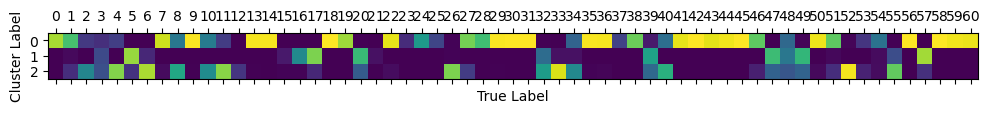

In [14]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.matshow(contingency.T)
ax.set_xlabel('True Label')
ax.set_ylabel('Cluster Label')
_=ax.set_xticks(np.arange(contingency.shape[0]))


## Metrics

Lots of metrics exist which we can use to evaluate the quality of this assignment.

**Purity**:
   - For each true label $i$, the purity is given by:
     $ \text{Purity}(L_i) = \frac{|L_i \cap C_j|}{|L_i|} $
   where $C_j$ is the primary cluster for $L_i$.
   - The overall purity is the weighted average of the purities of all true labels. $\text{Overall Purity} = \sum_{i=1}^{n} \left( \text{Purity}(L_i) \times \frac{|L_i|}{N} \right)$
   - Put into words *purity* measures how much the true label of the cluster (the location name) overlaps with the clusters we discover with a clustering algorithm. Overall Purity is the weighted sum, weighted by the size of the true labels (locations). Locations with few data points (relative to the others) should effect the overall purity less.


**Coverage**:
   - For each cluster $ j$, the coverage is given by:
     $\text{Coverage}(C_j) = \frac{|L_i \cap C_j|}{|C_j|} $
   where $L_i$ is the primary true label for cluster $j$.
   - The overall coverage is the weighted average of the coverages of all clusters.

**Bleed-through Analysis**:
   - For each true label \( i \), calculate the bleed-through as:
    $ \text{Bleed-through}(L_i) = 1 - \frac{|L_i \cap C_j|}{|L_i|} $
   where \( C_j \) is the primary cluster for $ L_i $.

**Consolidation Score**:
   - For each true label \( i \), the consolidation score can be defined as:
    $ \text{Consolidation}(L_i) = \frac{|L_i \cap C_j|}{\sum_{k} (L_i \cap C_k \neq \emptyset)}$
   where the sum is over all clusters $ k $ that have a non-empty intersection with$ L_i $.

**Unrepresented Labels**:
   - A true label \( i \) is considered unrepresented if:
    $ |L_i \cap C_j| < \theta$
   for all clusters $ j $, where $ \theta $ is a threshold.


### Purity.

Lets start with the purity. This makes the most sense to me as a metric.
A *good* clustering method would group the true labels together without dividing the locations too much. A little bleed through of the clusters into different labels is too be expected. If there is significant bleed through I would like to know why that is?

* Does it drift over time?
* Does it drift back and forth?
* Is it just right on the boundary between two (or more) behaviours?

Lets define a routine to calculate the purities and take a look at the individual cluster purities.

In [15]:
def ComputePurities(trueLabels, clusterLabels):
    # Compute the contingency matrix
    contingency = ComputeContingency(trueLabels, clusterLabels)
    
    # Calculate individual purities for each true label
    maxIntersection = contingency.max(axis=1)
    labelCounts = np.bincount(trueLabels)
    individualPurities = maxIntersection / labelCounts
    
    # Calculate the overall purity as a weighted average
    N = len(trueLabels)
    weights = labelCounts / N
    overallPurity = np.sum(individualPurities * weights)
    
    return overallPurity, individualPurities

In [16]:
overallPurity, individualPurities = ComputePurities(trueLabelsB,clusterLabels)

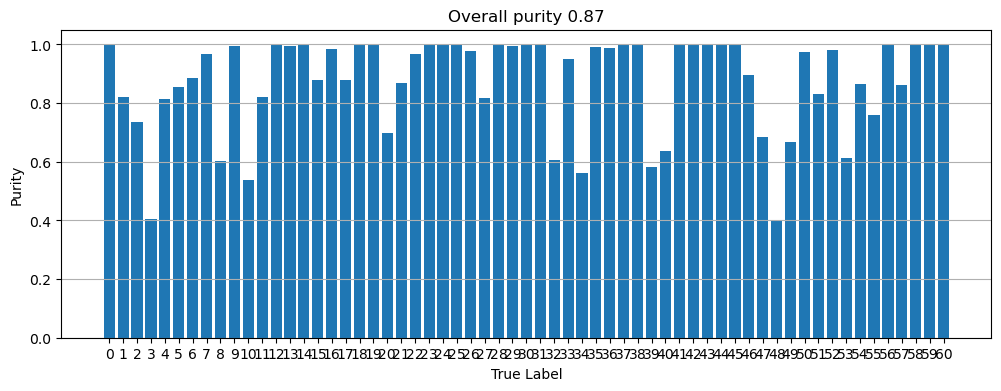

In [20]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.bar(np.unique(trueLabelsB),individualPurities)
ax.set_xlabel('True Label')
ax.set_ylabel('Purity')
ax.set_title(f"Overall purity {overallPurity:0.2f}")
ax.grid(axis='y')
_=ax.set_xticks(np.arange(contingency.shape[0]))

# Clustering on the PCA analysis

I think clustering on the reduced components coming out of the PCA analysis is a good idea.
So lets repeat our PCA analysis, lets just start with 5 components to keep things simple. Later we will play with this number.

Calculating the primary clusters is pretty simple

In [7]:
def get_pca_from_pipeline(pipeline):
    for step in pipeline.steps:
        if isinstance(step[1], PCA):
            return step[1]
    return None

pipeline1 = Pipeline([
    ('pca', PCA(n_components = 5))  
])

fitted = pipeline1.fit_transform(arr)
pca = get_pca_from_pipeline(pipeline1)
comps = pca.components_

In [14]:
def ComputeBleedThrough(trueLabels, clusterLabels, primaryClusters):
    # Compute the contingency matrix
    contingency = ComputeContingency(trueLabels, clusterLabels)
    
    # Calculate individual bleed-through for each true label using the provided primary clusters
    intersections = np.array([contingency[i, primaryClusters[i]] for i in range(contingency.shape[0])])
    trueLabelCounts = np.bincount(trueLabels, minlength=contingency.shape[0])
    individualBleedThrough = 1 - (intersections / trueLabelCounts)
    
    # Calculate the weighted average bleed-through
    N = len(trueLabels)
    weights = trueLabelCounts / N
    weightedAverageBleedThrough = np.sum(individualBleedThrough * weights)
    
    return weightedAverageBleedThrough, individualBleedThrough

weightedAverageBleedThrough, individualBleedThrough = ComputeBleedThrough(trueLabelsIndexed, clusterLabelsIndexed, primaryLabels)

In [15]:
1 - individualBleedThrough
#individualPurities

array([1.        , 0.81904762, 0.73522976, 0.40318907, 0.81481481,
       0.85338866, 0.88595271, 0.9683908 , 0.60082305, 0.99588477,
       0.53787879, 0.82167353, 1.        , 0.9944675 , 1.        ,
       0.87719298, 0.98300283, 0.87987988, 0.99862826, 1.        ,
       0.6971831 , 0.86842105, 0.96827586, 1.        , 1.        ,
       1.        , 0.97829716, 0.81702128, 1.        , 0.99314129,
       0.99862826, 0.99725652, 0.60574018, 0.95165746, 0.5625    ,
       0.99176955, 0.98765432, 1.        , 1.        , 0.5821727 ,
       0.63823934, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.89525368, 0.68587106, 0.39368999, 0.66666667,
       0.9739369 , 0.83004552, 0.98216735, 0.61413043, 0.86335404,
       0.75994513, 1.        , 0.86282579, 1.        , 0.9972028 ,
       1.        ])

In [16]:
def ComputeCoverage(trueLabels, clusterLabels, primaryTrueLabels):
    # Compute the contingency matrix
    contingency = ComputeContingency(trueLabels, clusterLabels)
    
    # Calculate individual coverages for each cluster using the provided primary true labels
    maxIntersection = np.array([contingency[primaryTrueLabels[j], j] for j in range(contingency.shape[1])])
    clusterCounts = np.bincount(clusterLabels, minlength=contingency.shape[1])
    individualCoverages = maxIntersection / clusterCounts
    
    # Calculate the overall coverage as a weighted average
    N = len(clusterLabels)
    weights = clusterCounts / N
    overallCoverage = np.sum(individualCoverages * weights)
    
    return overallCoverage, individualCoverages


overallCoverage, individualCoverages = ComputeCoverage(trueLabelsIndexed, clusterLabelsIndexed, primaryLabels)
individualCoverages

array([0.02794949, 0.        , 0.03734993])

In [17]:
contingency = ComputeContingency(trueLabelsIndexed, clusterLabelsIndexed)
    
#    # Calculate individual coverages for each cluster using the provided primary true labels
maxIntersection = np.array([contingency[primaryLabels[j], j] for j in range(contingency.shape[1])])
#    clusterCounts = np.bincount(clusterLabels, minlength=contingency.shape[1])
#    individualCoverages = maxIntersection / clusterCounts

In [18]:
maxIntersection

array([633,   0, 336])

In [21]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Create the pipeline
pipeline = Pipeline([
    ('pca', PCA()),  # Number of components will be set in the loop
    ('kmeans', KMeans(n_init=10))  # Number of clusters will be set in the loop
])

# Lists to store results
pca_components_list = []
clusters_list = []
purity_list = []

# Loop over the number of PCA components and KMeans clusters
for n_components in range(1, 11):  # 1 to 10 PCA components
    for n_clusters in range(2, 9):  # 2 to 8 clusters
        # Set parameters
        pipeline.set_params(pca__n_components=n_components, kmeans__n_clusters=n_clusters)
        
        # Fit and predict using the pipeline
        pipeline.fit(arr)
        predicted_labels = pipeline.predict(arr)
        
        # Evaluate purity
        overall_purity, _ = ComputePurities(trueLabelsIndexed, predicted_labels)
        
        # Store results
        pca_components_list.append(n_components)
        clusters_list.append(n_clusters)
        purity_list.append(overall_purity)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'PCA_Components': pca_components_list,
    'KMeans_Clusters': clusters_list,
    'Purity': purity_list
})

print(results_df)

    PCA_Components  KMeans_Clusters    Purity
0                1                2  0.945632
1                1                3  0.873079
2                1                4  0.804266
3                1                5  0.764507
4                1                6  0.729544
..             ...              ...       ...
65              10                4  0.876413
66              10                5  0.800987
67              10                6  0.784481
68              10                7  0.770469
69              10                8  0.765564

[70 rows x 3 columns]


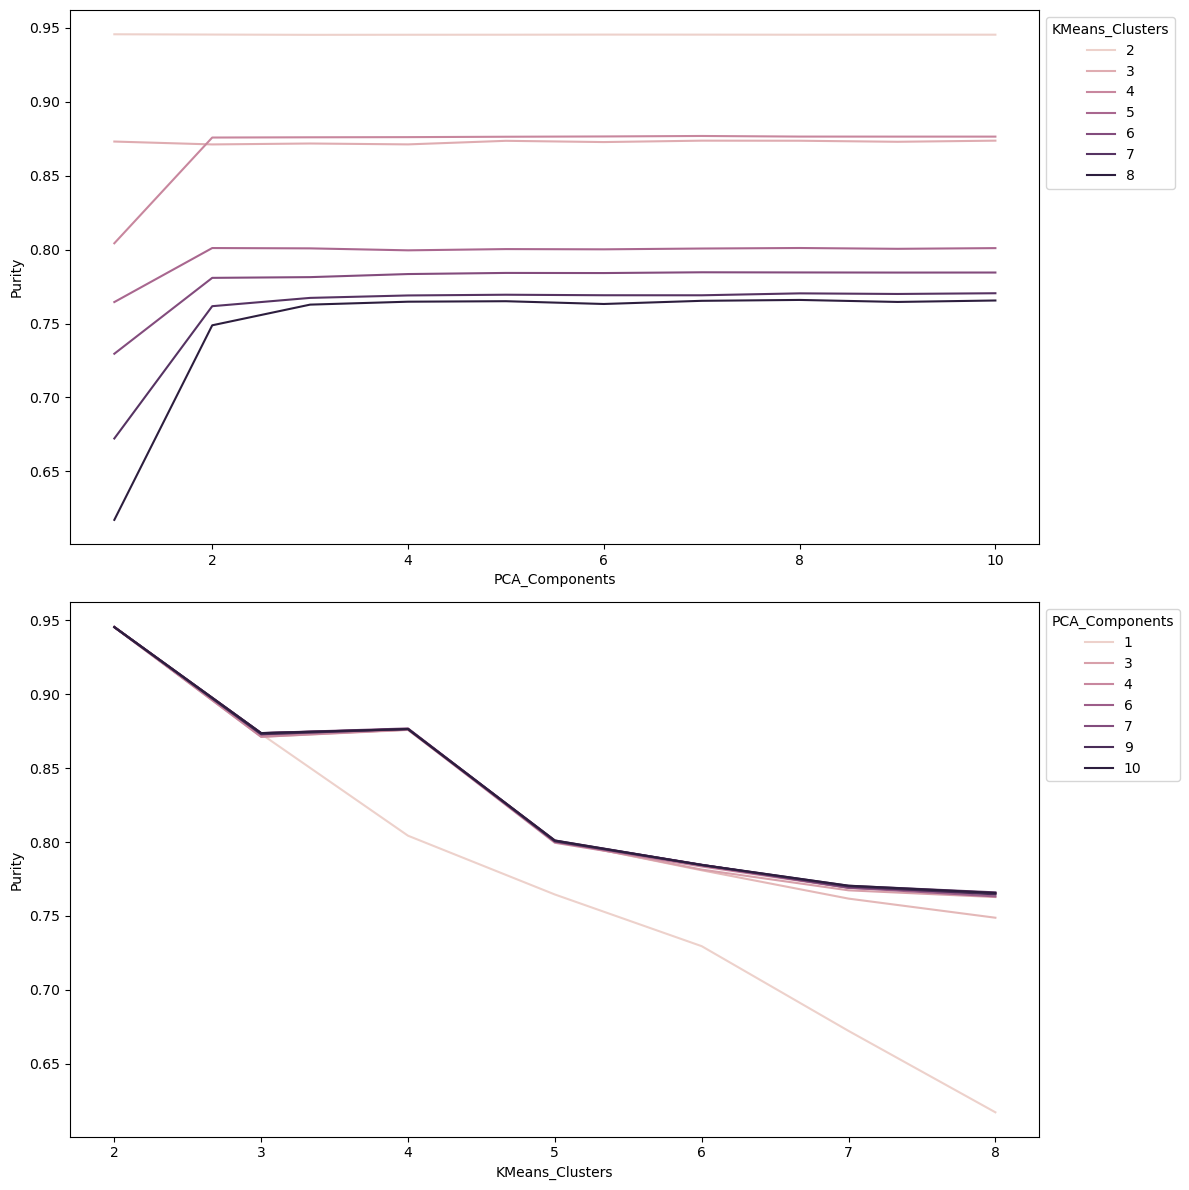

In [22]:
fig,axs = plt.subplots(2,1,figsize=(12,12))
sns.lineplot(data=results_df,x='PCA_Components',y='Purity',hue='KMeans_Clusters',ax=axs[0])
sns.lineplot(data=results_df,x='KMeans_Clusters',y='Purity',hue='PCA_Components',ax=axs[1])

for ax in axs:
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()

In [24]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Create the pipeline
pipeline = Pipeline([
    #('pca', PCA()),  # Number of components will be set in the loop
    ('kmeans', KMeans(n_init=10))  # Number of clusters will be set in the loop
])

# Lists to store results
pca_components_list = []
clusters_list = []
purity_list = []

# Loop over the number of PCA components and KMeans clusters
for n_clusters in range(2, 9):  # 2 to 8 clusters
    # Set parameters
    pipeline.set_params(kmeans__n_clusters=n_clusters)
        
    # Fit and predict using the pipeline
    pipeline.fit(arr)
    predicted_labels = pipeline.predict(arr)
        
    # Evaluate purity
    overall_purity, _ = ComputePurities(trueLabelsIndexed, predicted_labels)
        
    # Store results
    clusters_list.append(n_clusters)
    purity_list.append(overall_purity)

# Create a DataFrame to store the results
results2_df = pd.DataFrame({
    #'PCA_Components': pca_components_list,
    'KMeans_Clusters': clusters_list,
    'Purity': purity_list
})

    PCA_Components  KMeans_Clusters    Purity
0                1                2  0.945632
1                1                3  0.873079
2                1                4  0.804266
3                1                5  0.764507
4                1                6  0.729544
..             ...              ...       ...
65              10                4  0.876413
66              10                5  0.800987
67              10                6  0.784481
68              10                7  0.770469
69              10                8  0.765564

[70 rows x 3 columns]
